In [1]:
from pyspark.sql import SparkSession
from operator import add
import pyspark.sql.functions as f
from functools import reduce

In [2]:
# New API
spark_session = SparkSession\
        .builder\
        .appName("dataAnalysis")\
        .config("spark.executor.cores",2)\
        .config("spark.cores.max", 4)\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/hadoop/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-03-15 12:50:49,550 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
2022-03-15 12:51:09,103 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
2022-03-15 12:51:09,119 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM 

In [3]:
data_frame = spark_session.read.csv('hdfs://192.168.2.112:9000/user/ubuntu/million_song_dataset/million_song_subset_1gb_1.csv')
data_frame.show(10)

2022-03-15 12:51:29,558 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-------------------+-------------------+------------------+--------------------+---------------+-----------------+---------------+----------------+---------------+--------------------+--------------------+------------------+-------------------+--------------------+----------------+---------------+--------------------+-----------------+-------------------+--------------------+--------------------+------------+--------+--------------+------+----+--------------+--------+----+---------------+-----------------+-------+--------------+--------------------+------------------+--------------+-------------------+----------------+---------------+--------------------+--------------------+--------------------+--------------+-------------------+-----------+----------------+----------+---------------+------------+-----------------+-------------+-------------------+----+
|               _c0|                _c1|                _c2|               _c3|                 _c4|            _

In [4]:
def trim_genre(genre):
    """ UDF funtion that strips the genres of quotation marks and spaces. """
    return genre.strip(' ').strip('"')

def mapper(genres_and_hotness):
    """
    Mapper function used to pair hotness to genres. It pairs every genre in a list to an inputed hotness score.
    
    genres_and_hotness is a tuple that contains a list and a number.
    The list is a list of genres and the number is the hotness that each genre in the list is supposed to have.
    Here we pair that single hotness value to every genre in the list and return that.
    Example input: (['grunge', 'rock', 'pop'], 0.5)
    Example output: (('grunge', 0.5), ('rock', 0.5), ('pop', 0.5))
    """
    
    # genres_and_hotness[0] is a list of genres
    # genres_and_hotness[1] is the hotness score
    return ((genre, genres_and_hotness[1]) for genre in genres_and_hotness[0])

# Create trim_genre udf
trim_genre = f.udf(trim_genre)

# Get list of genres for a single artist (_c17) and trim that list.
# get also the hotness for that artist (_c2)
# Filter out the line that contains 'artist_terms' (that is only the first line)
# Convert the hotness column from string to float
# map it.
genres_and_hotness_df = data_frame.select(f.split(trim_genre(data_frame['_c17']), '" "'), '_c2')\
                        .filter(data_frame['_c17'] != 'artist_terms')\
                        .withColumn('_c2', data_frame['_c2'].cast('float').alias('_c2'))\
                        .rdd.map(lambda x: x)

# Create a flatmap of genre and hotness pairs.
mappings = genres_and_hotness_df.flatMap(mapper)

# map the genres, so we can count how often they appear
# reduceByKey is summing up the values of the hotness for each genre and also summing up how often each genre appears.
# filter is filtering out genres that appear too infrequently.
# mapValues is creating the average by dividing the sum of the hotness values with the count of how often a genre appears.
avg_rdd = mappings.mapValues(lambda x: (x, 1))\
                  .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
                  .filter(lambda x: x[1][1] > 1000)\
                  .mapValues(lambda x: x[0] / x[1])

# ordering it to return the highest valued genres first.
print(avg_rdd.takeOrdered(20, key=lambda x: -x[1]))


[('piano rock', 0.6182291512178814), ('female artist', 0.5774851354008803), ('celtic punk', 0.5684918165206909), ('soul music', 0.5484946156341722), ('emo pop', 0.5318947867000293), ('rap metal', 0.5311634882035914), ('jangle', 0.5287325140957634), ('dance pop', 0.527389485537546), ('golden age', 0.5252481275398015), ('teen pop', 0.5251352464154219), ('aggressive', 0.5215686238116448), ('eerie', 0.5204120874404907), ('crunk', 0.5193406785616702), ('american trad rock', 0.516848406316112), ('heavy', 0.5155343351305253), ('christian punk', 0.5149179875090691), ('influential', 0.5141249149783219), ('emo rock', 0.514052338940974), ('high school', 0.5123568569291223), ('emotional', 0.5086058054222073)]


<AxesSubplot:xlabel='names'>

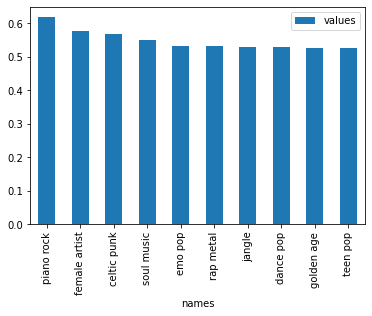

In [5]:
import pandas as pd
data_list = avg_rdd.takeOrdered(10, key=lambda x: -x[1])
plot_data = pd.DataFrame({'names': [x[0] for x in data_list], 'values': [x[1] for x in data_list]})
plot_data.plot.bar(x='names', y='values')